In [7]:
!export GEOMSTATS_BACKEND=torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from geomstats.geometry.hyperbolic import Hyperbolic
from geomstats.learning.frechet_mean import FrechetMean

from tqdm import tqdm

In [8]:
EMBED_PATH = "data/16d_hyperbolic_otu_embeddings.csv"
# EMBED_PATH = "data/128d_hyperbolic_otu_embeddings.csv"
HYPERBOLIC = True

In [9]:
data = {"ibd": {}, "moms": {}, "t2d": {}}
embedded_data = {"ibd": {}, "moms": {}, "t2d": {}}

embeddings = pd.read_csv(
    EMBED_PATH, dtype={0: str}
)
embeddings = embeddings.set_index(embeddings.columns[0])

# Now populate the data dict
for name in ["ibd", "moms", "t2d"]:
# for name in ["t2d"]:
# for name in ["ibd"]:
    for cutoff in [99, 97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61]:
        df = pd.read_csv(
            f"/home/phil/phylosig/ihmp/clustered/{name}/otus_{cutoff}.csv",
            index_col=["site", "patient", "visit", "sample"],
        )

        # This matrix multiplication does the weighted sum for us, if our
        # data is normalized - in this case it already is

        data[name][cutoff] = df
        embed = embeddings.reindex(df.columns)

        # Reindex the embeddings to match the columns of the dataframe
        if HYPERBOLIC:
            dim = embeddings.shape[1]
            hyp = Hyperbolic(dim=dim, default_coords_type="ball")
            fmean = FrechetMean(hyp.metric, max_iter=100)

            mixture_embeddings = np.zeros((df.shape[0], dim))
            for i, sample in tqdm(enumerate(df.index), total=df.shape[0]):
                mixture_embeddings[i] = fmean.fit(
                    embed,
                    weights=df.loc[sample].values
                ).estimate_

            embedded_data[name][cutoff] = mixture_embeddings
        else:
            embedded_data[name][cutoff] = df @ embed


100%|██████████| 2304/2304 [00:03<00:00, 694.64it/s] 


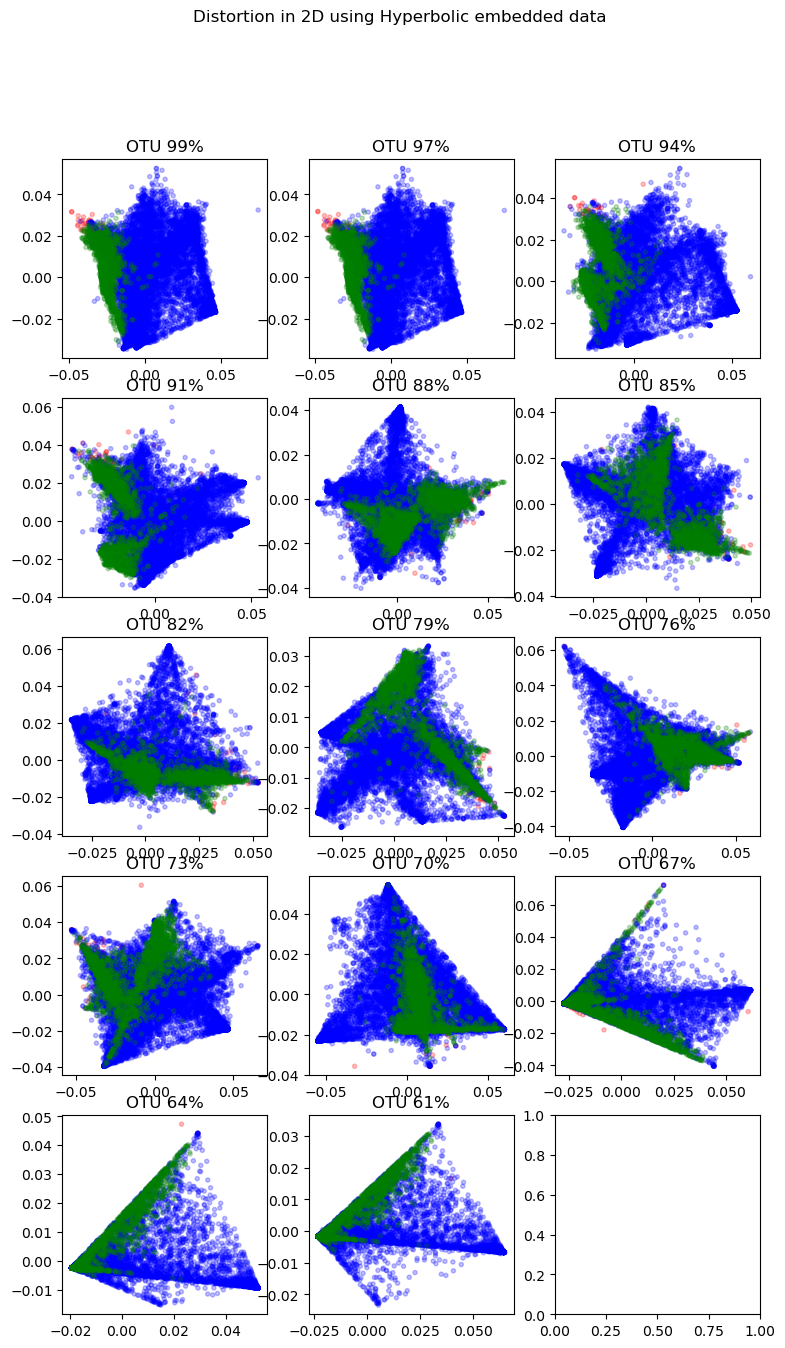

In [10]:
# Plot data with PCA in 2-d

fig, axs = plt.subplots(5, 3, figsize=(9, 15))
labels = (
    ["red"] * len(data["ibd"][99])
    + ["blue"] * len(data["moms"][99])
    + ["green"] * len(data["t2d"][99])
)

for i, size in enumerate([99, 97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61]):
    # df = pd.concat(
    df = np.vstack(
        [embedded_data[name][size] for name in ["ibd", "moms", "t2d"]]
    )
    # Get the PCA
    pca = PCA(n_components=2)
    pca.fit(df)
    # Transform the data
    transformed = pca.transform(df)
    # Plot the data
    axs[i // 3, i % 3].scatter(
        transformed[:, 0],
        transformed[:, 1],
        c=labels,
        s=9,
        alpha=0.25
    )
    axs[i // 3, i % 3].set_title(f"OTU {size}%")
    # axs[i // 3, i % 3].legend()

plt.suptitle("Distortion in 2D using Hyperbolic embedded data")
plt.show()


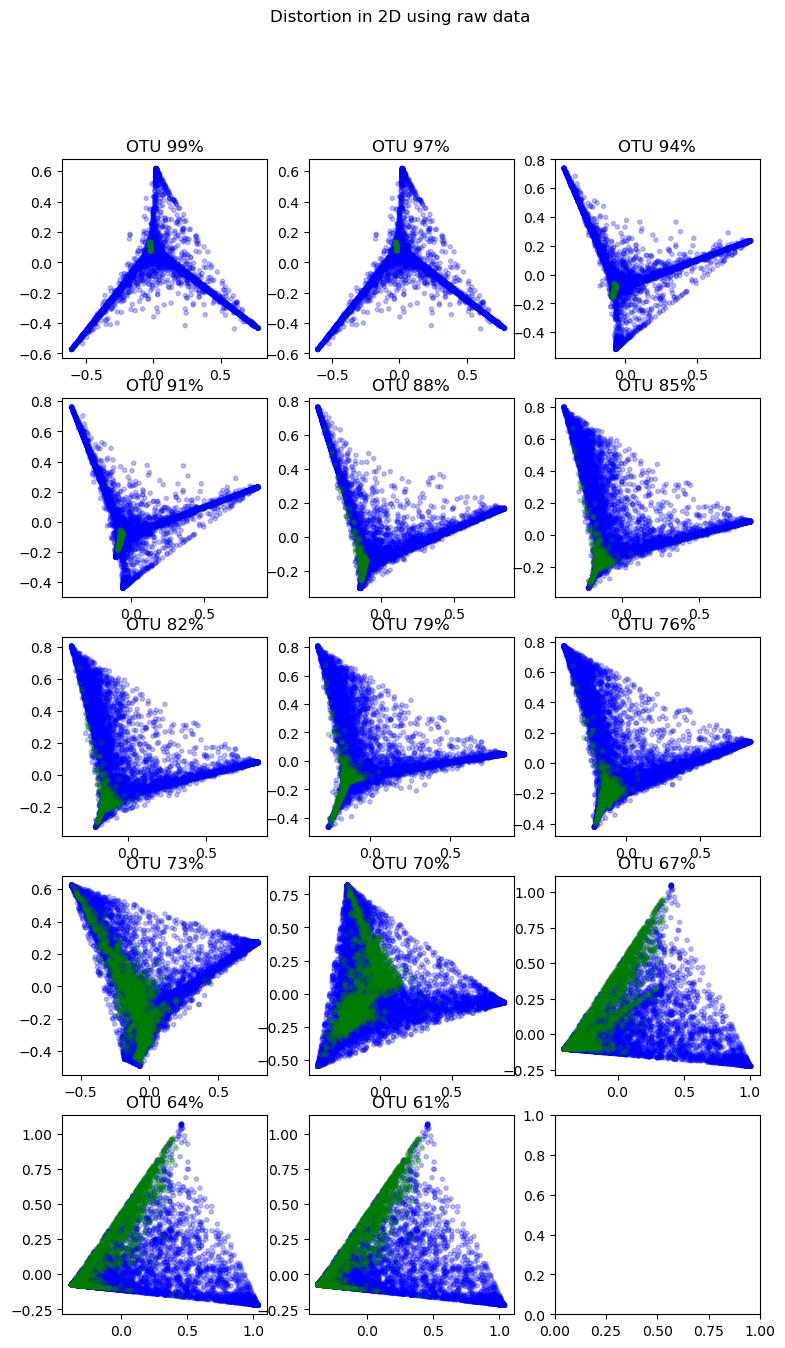

In [ ]:
# Plot data with PCA in 2-d

fig, axs = plt.subplots(5, 3, figsize=(9, 15))

for i, size in enumerate([99, 97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61]):
    df = pd.concat(
        [data[name][size] for name in ["ibd", "moms", "t2d"]]
    ).fillna(0)
    # Get the PCA
    pca = PCA(n_components=2)
    pca.fit(df)
    # Transform the data
    transformed = pca.transform(df)
    # Plot the data
    axs[i // 3, i % 3].scatter(
        transformed[:, 0],
        transformed[:, 1],
        c=labels,
        s=9,
        alpha=0.25
    )
    axs[i // 3, i % 3].set_title(f"OTU {size}%")
    # axs[i // 3, i % 3].legend()

plt.suptitle("Distortion in 2D using raw data")
plt.show()


In [12]:
# Measure distortion in pairwise distances between samples
# Using efficient pairwise distance calculation

from scipy.spatial.distance import pdist, squareform
from geomstats.geometry.hyperbolic import Hyperbolic

hyp = Hyperbolic(dim=128, default_coords_type="ball")

dists = {"ibd": {}, "moms": {}, "t2d": {}}
pca_dists = {"ibd": {}, "moms": {}, "t2d": {}}
embed_dists = {"ibd": {}, "moms": {}, "t2d": {}}

for name in ["ibd", "moms", "t2d"]:
    for cutoff in tqdm([99, 97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61]):

        dists[name][cutoff] = squareform(
            pdist(data[name][cutoff], metric="euclidean")
        )

        if data[name][cutoff].shape[1] > 16:
            pca_dists[name][cutoff] = squareform(
                pdist(
                    PCA(n_components=16).fit_transform(data[name][cutoff]), 
                    metric="euclidean")
            )
        else:
            pca_dists[name][cutoff] = dists[name][cutoff]

        embed_dists[name][cutoff] = squareform(
            pdist(embedded_data[name][cutoff], metric=hyp._metric.dist)
        )

In [11]:
# Compute distortions for embedded and non-embedded data

DATASET = "moms"

n = len(dists[DATASET])
corrs_nonembed = np.zeros((n,n))
corrs_embed = np.zeros((n,n))
corrs_pca = np.zeros((n,n))

cutoffs = [99, 97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61]
for i, cutoff_i in enumerate(cutoffs):
    for j, cutoff_j in enumerate(cutoffs):
        corrs_nonembed[i, j] = np.corrcoef(
            dists[DATASET][cutoff_i].flatten(),
            dists[DATASET][cutoff_j].flatten()
        )[0, 1]
        corrs_embed[i, j] = np.corrcoef(
            embed_dists[DATASET][cutoff_i].flatten(),
            embed_dists[DATASET][cutoff_j].flatten()

        )[0, 1]
        corrs_pca[i, j] = np.corrcoef(
            pca_dists[DATASET][cutoff_i].flatten(),
            pca_dists[DATASET][cutoff_j].flatten()
        )[0, 1]

NameError: name 'dists' is not defined

Text(0.5, 1.0, 'Raw data\nAverage correlation: 0.725')

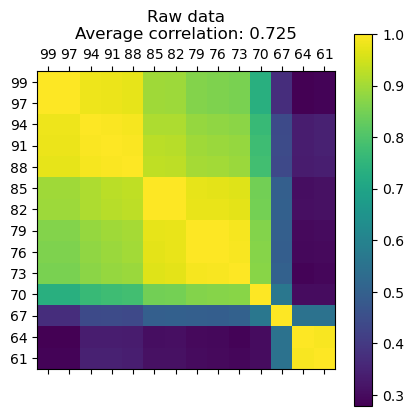

In [26]:
plt.matshow(corrs_nonembed)
plt.xticks(range(len(cutoffs)), cutoffs)
plt.yticks(range(len(cutoffs)), cutoffs)
plt.colorbar()
plt.title(f"Raw data\nAverage correlation: {np.mean(corrs_nonembed):.3f}")

Text(0.5, 1.0, '128-dimensional hyperbolic embedding\nAverage correlation: 0.760')

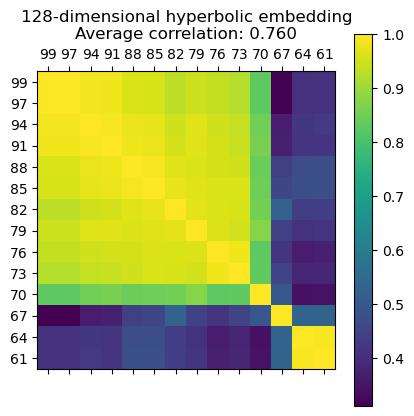

In [36]:
plt.matshow(corrs_embed)
plt.xticks(range(len(cutoffs)), cutoffs)
plt.yticks(range(len(cutoffs)), cutoffs)
plt.colorbar()
plt.title(f"128-dimensional hyperbolic embedding\nAverage correlation: {np.mean(corrs_embed):.3f}")

Text(0.5, 1.0, 'Raw data, top 16 PCs\nAverage correlation: 0.722')

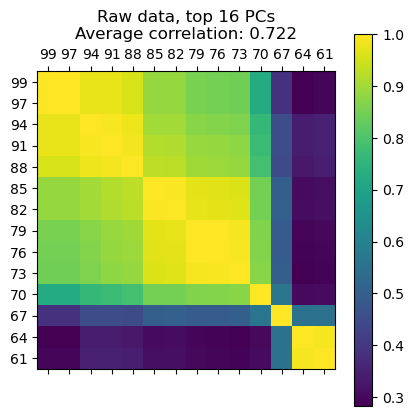

In [28]:
plt.matshow(corrs_pca)
plt.xticks(range(len(cutoffs)), cutoffs)
plt.yticks(range(len(cutoffs)), cutoffs)
plt.colorbar()
plt.title(f"Raw data, top 16 PCs\nAverage correlation: {np.mean(corrs_pca):.3f}")

In [15]:
print(corrs_nonembed.mean(), corrs_embed.mean(), corrs_pca.mean())

0.7247825540248802 0.7476372134725735 0.7220641509373071


/tmp/ipykernel_275192/4270070046.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([""])


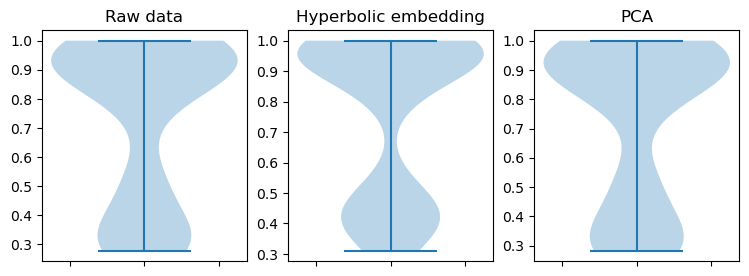

In [38]:
# Make a violin plot of pairwise distances

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

to_plot = [corrs_nonembed, corrs_embed, corrs_pca]
titles = ["Raw data", "Hyperbolic embedding", "PCA"]

for i in range(3):
    # axs[i].boxplot(to_plot[i].flatten())
    axs[i].violinplot(to_plot[i].flatten())
    axs[i].set_title(titles[i])
    axs[i].set_xticklabels([""])

/tmp/ipykernel_275192/2242282506.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(cutoffs)


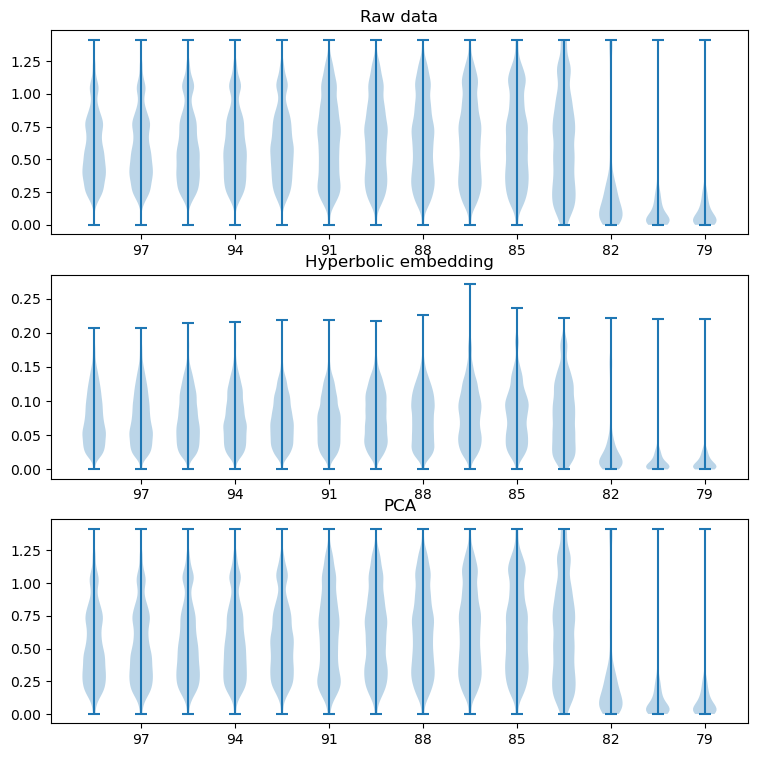

In [43]:
# Plot the actual distributions of distances

fig, axs = plt.subplots(3, 1, figsize=(9, 9))

for i, data in enumerate([dists, embed_dists, pca_dists]):
    to_plot = [data["ibd"][x].flatten() for x in cutoffs]
    axs[i].violinplot(to_plot)
    axs[i].set_title(titles[i])
    axs[i].set_xticklabels(cutoffs)

In [40]:
dists

{'ibd': {99: array([[0.        , 0.27539649, 0.30103074, ..., 0.68495109, 0.61756968,
          0.26556654],
         [0.27539649, 0.        , 0.15927699, ..., 0.60925276, 0.53389004,
          0.28052704],
         [0.30103074, 0.15927699, 0.        , ..., 0.61183953, 0.53778524,
          0.29459594],
         ...,
         [0.68495109, 0.60925276, 0.61183953, ..., 0.        , 0.45239945,
          0.51319063],
         [0.61756968, 0.53389004, 0.53778524, ..., 0.45239945, 0.        ,
          0.41664737],
         [0.26556654, 0.28052704, 0.29459594, ..., 0.51319063, 0.41664737,
          0.        ]]),
  97: array([[0.        , 0.27539649, 0.30103074, ..., 0.68495109, 0.61756968,
          0.26556654],
         [0.27539649, 0.        , 0.15927699, ..., 0.60925276, 0.53389004,
          0.28052704],
         [0.30103074, 0.15927699, 0.        , ..., 0.61183953, 0.53778524,
          0.29459594],
         ...,
         [0.68495109, 0.60925276, 0.61183953, ..., 0.        , 0.45239945